In [6]:
%load_ext autoreload
%autoreload 2


In [272]:
# load and filter osm network (step 1)
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import time
import networkx as nx
import math
import osmnx as ox
import numpy as np
import pickle
import rasterio as rt
import shapely
import GOSTnets as gn
#import peartree

# Get reference to GOSTNets
import sys
sys.path.insert(1,"/Users/ccsuehara/GH_folders/GOSTnets/GOSTnets")
from fetch_pois import *
from core import *

#from load_osm import losm
## Can't seem to work https://stackoverflow.com/questions/62858552/why-cant-i-import-geopy-distance-vincenty-on-jupyter-notebook-i-installed-ge


from shapely.geometry import Point, box, Polygon
from shapely.ops import unary_union, linemerge, transform
from shapely.wkt import loads
from shapely import wkt
from shapely.geometry import LineString, MultiLineString, Point

#### Might not use these
import fiona
from osgeo import gdal
import importlib
import matplotlib.pyplot as plt
import subprocess, glob


In [ ]:
##Popoulation sources 
##https://www.worldpop.org/geodata/listing?id=79

In [97]:
def classify_times(x):

    '''
    classsify penalty times according to how flooded a place is. 
    '''

    if x == -99999:
        y = 1
    if math.isnan(x):
        y = 1
    elif x <= 0:
        y = 1
    elif ((x > 0 ) & (x <= .1)):
        y = 2
    elif ((x > .1) & (x <= .25)):
        y = 5
    elif ((x > .25) & (x <= .35)):
        y = 5
    elif ((x > .35) & (x <= .5)):
        y = 9999       
    elif ((x > .35) & (x <= .5)):
        y = 9999
    elif x > .5:
        y = 9999

    return y

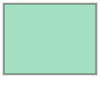

In [3]:
city = gpd.read_file("../data/Kumasi_shp/clipping_boundary.geojson").set_crs(epsg=4326)
bound = city.geometry.iloc[0]
bound.buffer(0)

In [165]:

adm2 = gpd.read_file("../data/GHA_ADM.gpkg", layer='GHA_ADM2')
relevant_adms = ['7','25', '27', '28',
                 '16571', '190719', '190720']

relevant_adms = [7,25, 27, 28,
                 16571, 190719, 190720]
kumasi = adm2[adm2['ADM2_CODE'].isin(relevant_adms)]

In [166]:
kumasi

,ADM2_CODE,ADM2_NAME,ADM1_CODE,ADM1_NAME,ADM0_CODE,ADM0_NAME,STATUS,DISP_AREA,geometry
206,190719,Asokore Mampong Muni,1324,Ashanti,94,Ghana,Member State,NO,"MULTIPOLYGON (((-1.56675 6.73462, -1.56635 6.7..."
207,190720,Kumasi Metropolitan,1324,Ashanti,94,Ghana,Member State,NO,"MULTIPOLYGON (((-1.60099 6.70861, -1.60286 6.7..."
220,16571,Kwadaso Municipal,1324,Ashanti,94,Ghana,Member State,NO,"MULTIPOLYGON (((-1.59860 6.61369, -1.60091 6.6..."
234,25,Oforikrom Municipal,1324,Ashanti,94,Ghana,Member State,NO,"MULTIPOLYGON (((-1.51608 6.64385, -1.51656 6.6..."
235,7,Asokwa Municipal,1324,Ashanti,94,Ghana,Member State,NO,"MULTIPOLYGON (((-1.55448 6.64291, -1.55449 6.6..."
236,27,Old Tafo Municipal,1324,Ashanti,94,Ghana,Member State,NO,"MULTIPOLYGON (((-1.64246 6.75867, -1.64085 6.7..."
237,28,Suame Municipal,1324,Ashanti,94,Ghana,Member State,NO,"MULTIPOLYGON (((-1.67654 6.76690, -1.67583 6.7..."


In [161]:
#adm2[adm2['ADM1_NAME'] == "Ashanti"]['ADM2_NAME'].value_counts()


Adenta Municipal        1
Kwahu Afram Plains N    1
Ayensuano               1
Abuakwa South           1
Upper West Akim         1
                       ..
Komenda-edina-eguafo    1
Sefwi-wiawso            1
Asunafo South           1
Nkoranza South          1
Birim Central Munici    1
Name: ADM2_NAME, Length: 260, dtype: int64

In [206]:
#gDrive = ox.graph_from_polygon(bound, network_type= 'all', simplify=False, clean_periphery=False)
#gDrive = ox.project_graph(gDrive, to_crs='epsg:4326')

#gn.save(gDrive, '../data/Graphs/Kumasi', '', edges = True, nodes = True)

# If restarting, reload.
gDrive = nx.read_gpickle("../data/Graphs/Kumasi.pickle")

gDrive_node_gdf = gn.node_gdf_from_graph(gDrive)
gDrive_edge_gdf = gn.edge_gdf_from_graph(gDrive)

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


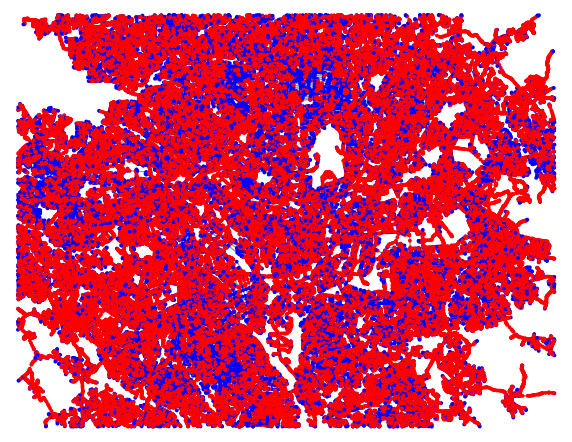

In [280]:
nc = ['b' if ox.simplification._is_endpoint(gDrive, node) else 'r' for node in gDrive.nodes()]
fig, ax = ox.plot_graph(gDrive, node_color=nc, node_zorder=3, bgcolor='#FFFFFF',figsize=(10, 10))

In [281]:
list_of_subgraphs = [gDrive.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(gDrive), key=len, reverse=True)]
G_largest = list_of_subgraphs[0]
G_second_largest = list_of_subgraphs[1]
print(nx.info(G_largest))


MultiDiGraph with 131919 nodes and 279182 edges


In [283]:
print(nx.info(gDrive))


MultiDiGraph with 131971 nodes and 279251 edges


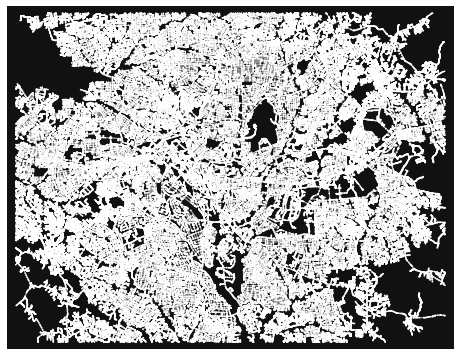

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [ ]:
# plotting functions only work if the graphs have a name and a crs attribute

# largest connected subgraph
ox.plot_graph(G_largest, edge_linewidth=1, node_size=3)

In [286]:
# simplify the network
gDrivesimp = ox.simplify_graph(gDrive)
print(nx.info(gDrivesimp))


MultiDiGraph with 28959 nodes and 76461 edges


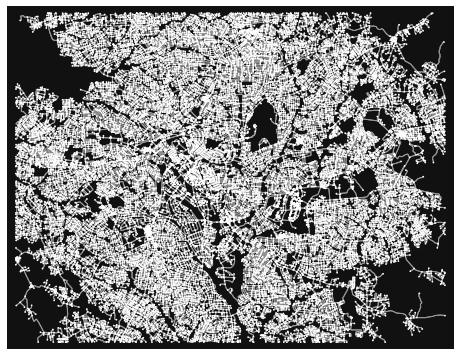

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [288]:
ox.plot_graph(gDrivesimp, edge_linewidth=1, node_size=3)

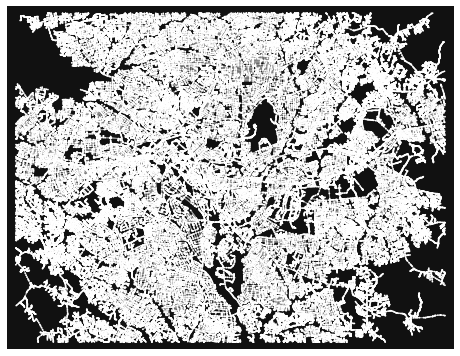

In [287]:
fig, ax = ox.plot_graph(gDrive, edge_linewidth=1, node_size=3)

In [208]:
speed_dict = {
                'residential': 40,  # kmph
                'primary': 80, 
                'primary_link':60,
                'trunk': 80,
                'trunk_link':60,
                'secondary': 70, 
                'secondary_link':50,
                'service': 40,
                'tertiary':60,
                'tertiary_link': 40,
                'unclassified':50, 
                'road':50,
                'track':25,
                'path':4.5,
                }


# residential       233239 ch
# service            10997 ch
# tertiary           10709 ch
# unclassified        8645 ch
# path                6022 ch
# secondary           2689 ch
# track               2070 ch
# trunk               1828 ch
# footway             1640 no
# primary              876 ch
# trunk_link           271 ch
# secondary_link       113 ch
# living_street         72  no
# primary_link          44 ch
# tertiary_link         28 ch
# cycleway               6 no
# pedestrian             2 no

In [209]:
gTime = gn.convert_network_to_time(gDrive, distance_tag = 'length', graph_type='drive', speed_dict = speed_dict)

In [210]:
gTime_node_gdf = gn.node_gdf_from_graph(gTime)
gTime_edge_gdf = gn.edge_gdf_from_graph(gTime)


/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [211]:
## Loading points of destination from "Create Pois.ipynb"
fread = open('../data/Kumasi_places.pickle', "rb")
pod = pickle.load(fread)

In [200]:
dic_pandana = {}
for key, val in pod.items():
    gdf = gn.pandana_snap_c(gDrive, val,  add_dist_to_node_col = True)
    dic_pandana[key] = gdf

In [201]:
with open('../data/pandana_pod_Kumasi_pandana_c.pickle', 'wb') as handle:
    pickle.dump(dic_pandana, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
population = gpd.read_file('../data/Kumasi/Kumasi_pop_unadj_2020.shp').set_crs(epsg=4326)
population['centroid'] = population['geometry'].centroid
population = gpd.GeoDataFrame(population, geometry = population['centroid']).set_crs(epsg=4326)

/var/folders/fw/9znznnm56pn2r_tnfxv4lcfc0000gn/T/ipykernel_69260/864416107.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  population['centroid'] = population['geometry'].centroid


In [44]:
gdf_popu = gn.pandana_snap_c(gDrive, population,  add_dist_to_node_col = True)

In [202]:

lst_places = {}
for key, val in dic_pandana.items():
    lst_places[key] = list(dic_pandana[key]['NN'].unique())

lst_places['population'] = list(gdf_popu['NN'].unique())

In [203]:
lst_destinations = lst_places['schools'] + lst_places['health'] + lst_places['police'] + lst_places['fire'] + lst_places['finance'] + lst_places['markets']
lst_origins = lst_places['population']
lst_destinations = list(set(lst_destinations))

destinations = list(dic_pandana.keys())

In [204]:
ev_5yr = gpd.read_file("../data/processed/Kumasi/merged/new/ev_5.shp")
ev_10yr = gpd.read_file("../data/processed/Kumasi/merged/new/ev_10.shp")
ev_20yr = gpd.read_file("../data/processed/Kumasi/merged/new/ev_20.shp")
ev_50yr = gpd.read_file("../data/processed/Kumasi/merged/new/ev_50.shp")
ev_100yr = gpd.read_file("../data/processed/Kumasi/merged/new/ev_100.shp")
ev_200yr = gpd.read_file("../data/processed/Kumasi/merged/new/ev_200.shp")


ev_5yr.crs = 'init=epsg:4326'
ev_10yr.crs = 'init=epsg:4326'
ev_20yr.crs = 'init=epsg:4326'
ev_50yr.crs = 'init=epsg:4326'
ev_100yr.crs = 'init=epsg:4326'
ev_200yr.crs = 'init=epsg:4326'

for x in [ev_5yr, ev_10yr,ev_20yr,ev_50yr,ev_100yr,ev_200yr]:
    x['DN'] = x['DN']/1000
    x.loc[x['DN'] == -9999, 'DN'] = 0

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [220]:
edge_5yr = gpd.sjoin(gTime_edge_gdf, ev_5yr, how = "left")
edge_10yr = gpd.sjoin(gTime_edge_gdf, ev_10yr, how = "left")
edge_20yr = gpd.sjoin(gTime_edge_gdf, ev_20yr, how = "left")
edge_50yr = gpd.sjoin(gTime_edge_gdf, ev_50yr, how = "left")
edge_100yr = gpd.sjoin(gTime_edge_gdf, ev_100yr, how = "left")
edge_200yr = gpd.sjoin(gTime_edge_gdf, ev_200yr, how = "left")


In [221]:
## Eliminating edges that duplicate because of intersecting more than one flood geometry, and keeping the most flooded.

edge_5yr.sort_values('DN', inplace = True)
edge_10yr.sort_values('DN', inplace = True)
edge_20yr.sort_values('DN', inplace = True)
edge_50yr.sort_values('DN', inplace = True)
edge_100yr.sort_values('DN', inplace = True)
edge_200yr.sort_values('DN', inplace = True)


edge_5yr = edge_5yr[~edge_5yr.fake_id.duplicated(keep='last')]
edge_10yr = edge_10yr[~edge_10yr.fake_id.duplicated(keep='last')]
edge_20yr = edge_20yr[~edge_20yr.fake_id.duplicated(keep='last')]
edge_50yr = edge_50yr[~edge_50yr.fake_id.duplicated(keep='last')]
edge_100yr = edge_100yr[~edge_100yr.fake_id.duplicated(keep='last')]
edge_200yr = edge_200yr[~edge_200yr.fake_id.duplicated(keep='last')]





In [223]:
for gdf in [edge_5yr, edge_10yr, edge_20yr, edge_50yr, edge_100yr, edge_200yr]:
    gdf['penalty_time'] =  (gdf['DN'].apply(lambda x: classify_times(x)))
    gdf['time'] = gdf['time'] * gdf['penalty_time']


In [251]:
edge_5yr.time.describe()

count    279251.000000
mean         70.937138
std        2135.422135
min           0.023760
25%           0.850239
50%           1.685970
75%           3.527640
max      276340.363200
Name: time, dtype: float64

In [263]:
newwwa = gTime_edge_gdf.copy()
newwwa['og_time'] = newwwa['time']
newwwa.drop(columns = ['time'], inplace = True)
newww = pd.merge(newwwa, edge_5yr, on = 'fake_id')


In [265]:
newww.columns

Index(['stnode_x', 'endnode_x', 'highway_x', 'access_x', 'lanes_x',
       'service_x', 'oneway_x', 'width_x', 'length_x', 'maxspeed_x',
       'tunnel_x', 'ref_x', 'mode_x', 'bridge_x', 'name_x', 'osmid_x',
       'junction_x', 'geometry_x', 'fake_id', 'og_time', 'stnode_y',
       'endnode_y', 'highway_y', 'access_y', 'lanes_y', 'service_y',
       'oneway_y', 'width_y', 'length_y', 'maxspeed_y', 'tunnel_y', 'ref_y',
       'mode_y', 'bridge_y', 'name_y', 'osmid_y', 'time', 'junction_y',
       'geometry_y', 'index_right', 'DN', 'penalty_time'],
      dtype='object')

In [315]:
#newww[newww['og_time'] == newww['time']][['og_time', 'time']]

edge_5yr.columns

Index(['stnode', 'endnode', 'highway', 'access', 'lanes', 'service', 'oneway',
       'width', 'length', 'maxspeed', 'tunnel', 'ref', 'mode', 'bridge',
       'name', 'osmid', 'time', 'junction', 'geometry', 'fake_id',
       'index_right', 'DN', 'penalty_time'],
      dtype='object')

In [321]:
## Other way of doing it :

# gTime_5yr = edges_and_nodes_gdf_to_graph(gDrive_node_gdf, edge_5yr,
#                                         node_tag='node_ID',
#                                         u_tag='stnode', v_tag='endnode',
#                                         geometry_tag='geometry')

## Construct networks
gTime_bb = nx.from_pandas_edgelist(
    gTime_edge_gdf,
    source="stnode",
    target="endnode",
    edge_attr=True,
)

gTime_5yr = nx.from_pandas_edgelist(
    edge_5yr,
    source="stnode",
    target="endnode",
    edge_attr=True,
)

# gTime_10yr = nx.from_pandas_edgelist(
#     edge_10yr,
#     source="stnode",
#     target="endnode",
#     edge_attr=True,
# )


# gTime_20yr = nx.from_pandas_edgelist(
#     edge_20yr,
#     source="stnode",
#     target="endnode",
#     edge_attr=True,
# )

# gTime_50yr = nx.from_pandas_edgelist(
#     edge_50yr,
#     source="stnode",
#     target="endnode",
#     edge_attr=True,
# )

# gTime_100yr = nx.from_pandas_edgelist(
#     edge_100yr,
#     source="stnode",
#     target="endnode",
#     edge_attr=True,
# )

# gTime_200yr = nx.from_pandas_edgelist(
#     edge_200yr,
#     source="stnode",
#     target="endnode",
#     edge_attr=True,
# )

In [323]:
### OD Matrices for each scenario: 
fail_value = 999999999
#OD_base = gn.calculate_OD(gTime, lst_origins, lst_destinations, fail_value, weight = 'time')
OD_base = gn.calculate_OD(gTime_bb, lst_origins, lst_destinations, fail_value, weight = 'time')
OD_5yr = gn.calculate_OD(gTime_5yr, lst_origins, lst_destinations, fail_value, weight = 'time')
# OD_10yr = gn.calculate_OD(gTime_10yr, lst_origins, lst_destinations, fail_value, weight = 'time')
# OD_20yr = gn.calculate_OD(gTime_20yr, lst_origins, lst_destinations, fail_value, weight = 'time')
# OD_50yr = gn.calculate_OD(gTime_50yr, lst_origins, lst_destinations, fail_value, weight = 'time')
# OD_100yr = gn.calculate_OD(gTime_100yr, lst_origins, lst_destinations, fail_value, weight = 'time')
# OD_200yr = gn.calculate_OD(gTime_200yr, lst_origins, lst_destinations, fail_value, weight = 'time')
#OD_250yr = gn.calculate_OD(gTime_250yr, lst_origins, lst_destinations, fail_value, weight = 'time')

In [319]:
OD_df_b2.loc[OD_df_b2.index == 4089157448, OD_df_b2.columns.isin(lst_places['schools'])].T.to_csv('../data/waaaschools_b2.csv')

In [324]:
# Create geodataframe based on OD matrix
OD_df_b = pd.DataFrame(OD_base, index = lst_origins, columns = lst_destinations)
OD_df_5yr = pd.DataFrame(OD_5yr, index = lst_origins, columns = lst_destinations)
# OD_df_10yr = pd.DataFrame(OD_10yr, index = lst_origins, columns = lst_destinations)
# OD_df_20yr = pd.DataFrame(OD_20yr, index = lst_origins, columns = lst_destinations)
# OD_df_50yr = pd.DataFrame(OD_50yr, index = lst_origins, columns = lst_destinations)
# OD_df_100yr = pd.DataFrame(OD_100yr, index = lst_origins, columns = lst_destinations)
# OD_df_200yr = pd.DataFrame(OD_200yr, index = lst_origins, columns = lst_destinations)
#OD_df_250yr = pd.DataFrame(OD_250yr, index = lst_origins, columns = lst_destinations)

In [278]:
OD_df_5yr.loc[OD_df_5yr.index == 4089157448, OD_df_5yr.columns.isin(lst_places['schools'])].T.to_csv('../data/waaaschools.csv')

In [279]:
OD_df_b.loc[OD_df_b.index == 4089157448, OD_df_5yr.columns.isin(lst_places['schools'])].T.to_csv('../data/waaaschools_5yr.csv')

In [120]:
def create_poi_and_df(list_points, df, name_col):

    '''
    create closest travel time to destination for each origin 
    list_points: list of a single kind of destinagion, eg markets. 

    df: OD matrix as a dataframe
    '''
    fail_value = 999999999

    result_df = df.loc[:, list_points]
    result_df = result_df[result_df < fail_value] / 60
    result_df[name_col] = 0
    sub = result_df.iloc[:,0:-1]
    result_df[name_col] = sub.min(axis = 1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
    # We can take the mean, or the max value, let's check that. 
    new_df = result_df[[name_col]]
    new_df['NN'] = new_df.index
    return new_df

In [325]:
OD_to_dest_b = {}
OD_to_dest_5y = {}
OD_to_dest_10y = {}
OD_to_dest_20y = {}
OD_to_dest_50y = {}
OD_to_dest_100y = {}
OD_to_dest_200y = {}



for key in destinations:
    OD_to_dest_b[key] = create_poi_and_df(lst_places[key], OD_df_b, key)
    OD_to_dest_5y[key] = create_poi_and_df(lst_places[key], OD_df_5yr, key)
    OD_to_dest_10y[key] = create_poi_and_df(lst_places[key], OD_df_10yr, key)
    OD_to_dest_20y[key] = create_poi_and_df(lst_places[key], OD_df_20yr, key)
    OD_to_dest_50y[key] = create_poi_and_df(lst_places[key], OD_df_50yr, key)
    OD_to_dest_100y[key] = create_poi_and_df(lst_places[key], OD_df_100yr, key)
    OD_to_dest_200y[key] = create_poi_and_df(lst_places[key], OD_df_200yr, key)

/var/folders/fw/9znznnm56pn2r_tnfxv4lcfc0000gn/T/ipykernel_69260/1840220719.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['NN'] = new_df.index
/var/folders/fw/9znznnm56pn2r_tnfxv4lcfc0000gn/T/ipykernel_69260/1840220719.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['NN'] = new_df.index
/var/folders/fw/9znznnm56pn2r_tnfxv4lcfc0000gn/T/ipykernel_69260/1840220719.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [326]:

dic_od_df = {'base': OD_to_dest_b,
              'ev_5': OD_to_dest_5y,
              'ev_10': OD_to_dest_10y,
              'ev_20': OD_to_dest_20y,
              'ev_50': OD_to_dest_50y,
              'ev_100': OD_to_dest_100y,
              'ev_200': OD_to_dest_200y}

dic_all = {}

for place in destinations:
    new_df = pd.DataFrame()
    new_df['NN'] = gdf_popu.NN.unique()
    for key, val in dic_od_df.items():
        new_df = new_df.merge(val[place], on = 'NN', how = 'left')
        new_df.rename(columns = {place: key }, inplace = True)
   # for ev in  ['ev_5', 'ev_10', 'ev_20', 'ev_50', 'ev_100', 'ev_200']:
        #new_df.loc[new_df[ev] < new_df['base'], ev] = new_df['base']    
    dic_all[place] = new_df
    
    

Index(['fid', 'DN', 'geometry', 'centroid', 'x', 'y', 'NN', 'NN_dist', 'base',
       'ev_5', 'ev_10', 'ev_20', 'ev_50', 'ev_100', 'ev_200'],
      dtype='object')

In [389]:
time_bins = list(range(0,255,5))
time_labels = list(range(1,len(bins)+1))


In [390]:
popu_schools = gdf_popu.merge(dic_all['schools'], on= 'NN', how = "left")
popu_schools.columns

for x in ['ev_5', 'ev_10', 'ev_20', 'ev_50', 'ev_100', 'ev_200']:
    popu_schools['dtime_' + x] = popu_schools[x] - popu_schools['base']
    popu_schools["worse_"  + x] = np.where(popu_schools['base'] < popu_schools[x],popu_schools['DN'],0)
    popu_schools["iso180_"  + x] = np.where(popu_schools[x] > 180,popu_schools['DN'],0)
    popu_schools["iso60_"  + x] = np.where(popu_schools[x] > 60,popu_schools['DN'],0)
    popu_schools['dtime_' + x + '_t'] = popu_schools["worse_"  + x] * popu_schools['dtime_' + x]
    popu_schools['dtime_' + x + '_t'] = popu_schools["worse_"  + x] * popu_schools['dtime_' + x]
    popu_schools['trunc_' + x] =  np.where(popu_schools[x] > 255,255,popu_schools[x])
    popu_schools['bins_' + x ] =  pd.cut(popu_schools['trunc_' + x],
                              bins = time_bins, labels = time_labels)
    
   

In [393]:
kumasi_schools = gpd.sjoin(popu_schools, kumasi, how = "inner", predicate ='intersects')
agg_kumasi_schools = kumasi_schools.groupby(['ADM2_NAME']).agg({'worse_ev_5': 'sum',
                                          'worse_ev_10': 'sum',
                                          'worse_ev_20': 'sum',
                                          'worse_ev_50': 'sum',
                                          'worse_ev_100': 'sum',
                                          'worse_ev_200': 'sum',
                                          'DN': 'sum',
                                           'dtime_' +  'ev_5' + '_t': 'sum',
                                           'dtime_' +  'ev_10' + '_t': 'sum',
                                           'dtime_' +  'ev_20' + '_t': 'sum',
                                           'dtime_' +  'ev_50' + '_t': 'sum',
                                           'dtime_' +  'ev_100' + '_t': 'sum',
                                           'dtime_' +  'ev_200' + '_t': 'sum',
                                           'iso180_' +  'ev_5' : 'sum',
                                           'iso180_' +  'ev_10': 'sum',
                                           'iso180_' +  'ev_20' : 'sum',
                                           'iso180_' +  'ev_50' : 'sum',
                                           'iso180_' +  'ev_100': 'sum',
                                           'iso180_' +  'ev_200': 'sum',
                                           'iso60_' +  'ev_5' : 'sum',
                                           'iso60_' +  'ev_10': 'sum',
                                           'iso60_' +  'ev_20' : 'sum',
                                           'iso60_' +  'ev_50' : 'sum',
                                           'iso60_' +  'ev_100': 'sum',
                                           'iso60_' +  'ev_200': 'sum'
                                          }).reset_index()

agg_kumasi_schools.to_csv("../data/results_kumasi_schools.csv")
kumasi_schools.to_csv("../data/schools_kumasi.csv")

In [401]:
kumasi_schools.shape

(23283, 66)

In [392]:
bins_sch = pd.DataFrame()
bins_sch['bins'] = range(1,51)
for x in ['ev_5', 'ev_10', 'ev_20', 'ev_50', 'ev_100', 'ev_200']:
    df = kumasi_schools[['bins_' + x,'DN']].groupby(['bins_' + x]).sum().reset_index()
    df.rename(columns = {'DN': x},inplace = True)
    bins_sch = bins_sch.merge(df, left_on = 'bins', right_on = 'bins_' + x)
bins_sch.to_csv("../data/bins_kumasi_schools.csv")

In [332]:
#

In [409]:
popu_health = gdf_popu.merge(dic_all['health'], on= 'NN', how = "left")
for x in ['ev_5', 'ev_10', 'ev_20', 'ev_50', 'ev_100', 'ev_200']:
    popu_health['dtime_' + x] = popu_health[x] - popu_health['base']
    popu_health["worse_"  + x] = np.where(popu_health['base'] < popu_health[x],popu_health['DN'],0)
    popu_health["iso180_"  + x] = np.where(popu_health[x] > 180,popu_health['DN'],0)
    popu_health["iso60_"  + x] = np.where(popu_health[x] > 60,popu_health['DN'],0)
    popu_health['dtime_' + x + '_t'] = popu_health["worse_"  + x] * popu_health['dtime_' + x]
    popu_health['dtime_' + x + '_t'] = popu_health["worse_"  + x] * popu_health['dtime_' + x]
    popu_health['trunc_' + x] =  np.where(popu_health[x] > 255,255,popu_health[x])

    popu_health['bins_' + x ] =  pd.cut(popu_health['trunc_' + x],
                              bins = time_bins, labels = time_labels)
    
kumasi_health = gpd.sjoin(popu_health, kumasi, how = "inner", predicate ='intersects')

agg_kumasi_health = kumasi_health.groupby(['ADM2_NAME']).agg({'worse_ev_5': 'sum',
                                          'worse_ev_10': 'sum',
                                          'worse_ev_20': 'sum',
                                          'worse_ev_50': 'sum',
                                          'worse_ev_100': 'sum',
                                          'worse_ev_200': 'sum',
                                          'DN': 'sum',
                                           'dtime_' +  'ev_5' + '_t': 'sum',
                                           'dtime_' +  'ev_10' + '_t': 'sum',
                                           'dtime_' +  'ev_20' + '_t': 'sum',
                                           'dtime_' +  'ev_50' + '_t': 'sum',
                                           'dtime_' +  'ev_100' + '_t': 'sum',
                                           'dtime_' +  'ev_200' + '_t': 'sum',
                                           'iso180_' +  'ev_5' : 'sum',
                                           'iso180_' +  'ev_10': 'sum',
                                           'iso180_' +  'ev_20' : 'sum',
                                           'iso180_' +  'ev_50' : 'sum',
                                           'iso180_' +  'ev_100': 'sum',
                                           'iso180_' +  'ev_200': 'sum',
                                           'iso60_' +  'ev_5' : 'sum',
                                           'iso60_' +  'ev_10': 'sum',
                                           'iso60_' +  'ev_20' : 'sum',
                                           'iso60_' +  'ev_50' : 'sum',
                                           'iso60_' +  'ev_100': 'sum',
                                           'iso60_' +  'ev_200': 'sum'
                                          }).reset_index()

agg_kumasi_health.to_csv("../data/results_kumasi_hospitals.csv")
kumasi_health.to_csv("../data/health_kumasi.csv")

In [395]:
bins_h = pd.DataFrame()
bins_h['bins'] = range(1,51)
for x in ['ev_5', 'ev_10', 'ev_20', 'ev_50', 'ev_100', 'ev_200']:
    df = kumasi_health[['bins_' + x,'DN']].groupby(['bins_' + x]).sum().reset_index()
    df.rename(columns = {'DN': x},inplace = True)
    bins_sch = bins_h.merge(df, left_on = 'bins', right_on = 'bins_' + x)
bins_h.to_csv("../data/bins_kumasi_health.csv")

In [410]:
popu_markets = gdf_popu.merge(dic_all['markets'], on= 'NN', how = "left")

for x in ['ev_5', 'ev_10', 'ev_20', 'ev_50', 'ev_100', 'ev_200']:
    popu_markets['dtime_' + x] = popu_markets[x] - popu_markets['base']
    popu_markets["worse_"  + x] = np.where(popu_markets['base'] < popu_markets[x],popu_markets['DN'],0)
    popu_markets["iso180_"  + x] = np.where(popu_markets[x] > 180,popu_markets['DN'],0)
    popu_markets["iso60_"  + x] = np.where(popu_markets[x] > 60,popu_markets['DN'],0)
    popu_markets['dtime_' + x + '_t'] = popu_markets["worse_"  + x] * popu_markets['dtime_' + x]
    popu_markets['dtime_' + x + '_t'] = popu_markets["worse_"  + x] * popu_markets['dtime_' + x]
    popu_markets['trunc_' + x] =  np.where(popu_markets[x] > 255,255,popu_markets[x])
    popu_markets['bins_' + x ] =  pd.cut(popu_markets['trunc_' + x],
                              bins = time_bins, labels = time_labels)

In [411]:
kumasi_markets = gpd.sjoin(popu_markets, kumasi, how = "inner", predicate ='intersects')
agg_kumasi_markets = kumasi_markets.groupby(['ADM2_NAME']).agg({'worse_ev_5': 'sum',
                                          'worse_ev_10': 'sum',
                                          'worse_ev_20': 'sum',
                                          'worse_ev_50': 'sum',
                                          'worse_ev_100': 'sum',
                                          'worse_ev_200': 'sum',
                                          'DN': 'sum',
                                           'dtime_' +  'ev_5' + '_t': 'sum',
                                           'dtime_' +  'ev_10' + '_t': 'sum',
                                           'dtime_' +  'ev_20' + '_t': 'sum',
                                           'dtime_' +  'ev_50' + '_t': 'sum',
                                           'dtime_' +  'ev_100' + '_t': 'sum',
                                           'dtime_' +  'ev_200' + '_t': 'sum',
                                           'iso180_' +  'ev_5' : 'sum',
                                           'iso180_' +  'ev_10': 'sum',
                                           'iso180_' +  'ev_20' : 'sum',
                                           'iso180_' +  'ev_50' : 'sum',
                                           'iso180_' +  'ev_100': 'sum',
                                           'iso180_' +  'ev_200': 'sum',
                                           'iso60_' +  'ev_5' : 'sum',
                                           'iso60_' +  'ev_10': 'sum',
                                           'iso60_' +  'ev_20' : 'sum',
                                           'iso60_' +  'ev_50' : 'sum',
                                           'iso60_' +  'ev_100': 'sum',
                                           'iso60_' +  'ev_200': 'sum'
                                          }).reset_index()

agg_kumasi_markets.to_csv("../data/results_kumasi_markets.csv")
kumasi_markets.to_csv("../data/markets_kumasi.csv")

In [407]:
dic_all['health']

,NN,base,ev_5,ev_10,ev_20,ev_50,ev_100,ev_200
0,5977332006,9.508272,15.274721,17.819325,2211.922617,3177.568587,3177.685254,4653.658415
1,5977332986,8.558502,14.324951,16.869555,2210.972847,3176.618817,3176.735484,4652.708645
2,6006850455,7.160082,12.926530,14.392316,2208.495608,3174.141578,3174.258245,4650.231406
3,6004351037,7.013212,12.779661,14.245446,2208.348739,3173.994708,3174.111375,4650.084537
4,5989692089,6.545219,12.311668,13.777454,2207.880746,3173.526715,3173.643382,4649.616544
...,...,...,...,...,...,...,...,...
28817,3194211803,7.227416,7.227416,8.632560,8.719588,10.484571,1645.045868,2382.338845
28818,5996197233,7.480571,7.480571,8.885715,8.972743,10.737726,1645.299023,2382.592000
28819,5996197237,7.590623,7.590623,8.995767,9.082795,10.847778,1645.409075,2382.702052
28820,6006629328,8.072694,8.072694,8.139603,8.267119,9.537957,1644.099255,2381.392232


In [408]:
dic_all['markets']

,NN,base,ev_5,ev_10,ev_20,ev_50,ev_100,ev_200
0,5977332006,9.788288,14.644750,17.189354,2211.665475,3177.311445,3177.428112,4653.401273
1,5977332986,8.838518,13.694980,16.239584,2210.715705,3176.361675,3176.478342,4652.451503
2,6006850455,7.440097,12.296559,13.762345,2208.238466,3173.884436,3174.001103,4649.974264
3,6004351037,7.293228,12.149690,13.615476,2208.091597,3173.737566,3173.854233,4649.827395
4,5989692089,6.825235,11.681697,13.147483,2207.623604,3173.269573,3173.386240,4649.359402
...,...,...,...,...,...,...,...,...
28817,3194211803,7.041630,7.041630,8.446775,8.533803,10.298785,1644.860082,2382.153059
28818,5996197233,7.294785,7.294785,8.699929,8.786958,10.551940,1645.113237,2382.406214
28819,5996197237,7.404837,7.404837,8.809981,8.897010,10.661992,1645.223289,2382.516266
28820,6006629328,7.886908,7.886908,7.953817,8.081334,9.352172,1643.913469,2381.206446
